In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.dw1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
        )

        self.dw2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),            
        )

        self.dw_latent = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(20 * 20 * 64, 256),
        )
        
        self.latent = nn.Linear(256, 256)
        
        self.up_latent = nn.Sequential(
            nn.Linear(128, 256),
            nn.Linear(256, 20 * 20 * 64),            
        )

        self.up1 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5) 
        )

        self.up2 = nn.Sequential(            
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5) 
        )

        self.act = nn.Sigmoid()


    def forward(self, x):
        enc = self.dw2(self.dw1(x))
        lat = self.latent(self.dw_latent(enc))
        mu, lv = self.unwrap(lat)
        rec_lat = self.up_latent(self.reparam(mu, lv))
        dec = self.up2(self.up1(rec_lat.view(-1, 64, 20, 20)))
        
        return self.act(dec), mu, lv

    def unwrap(self, x):
        return torch.split(x, x.shape[1]//2, dim=1)

    def reparam(self, mu, lv):
        if self.training:
            std = torch.exp(0.5 * lv)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

In [3]:
def gaussian_kls(mu, logvar, mean=False):

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())

    if mean:
        reduce = lambda x: torch.mean(x, 1)
    else:
        reduce = lambda x: torch.sum(x, 1)

    total_kld = reduce(klds).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = reduce(klds).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=2048, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=2048, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

30 5


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.0001)

loss_fn = nn.BCELoss()

In [6]:
for epoch in range(1000):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss, _, _ = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 0 - TrainLoss: 0.9507688641548157 - ValidLoss: 0.6608312129974365


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 1 - TrainLoss: 0.4692897588014603 - ValidLoss: 0.504730349779129


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 2 - TrainLoss: 0.10960879465565085 - ValidLoss: 0.13059970885515212


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 3 - TrainLoss: -0.5639485354224841 - ValidLoss: -0.6507360696792602


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 4 - TrainLoss: -2.1708197553952533 - ValidLoss: -3.5256326675415037


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 5 - TrainLoss: -5.891450627644857 - ValidLoss: -7.701611804962158


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 6 - TrainLoss: -9.268800067901612 - ValidLoss: -11.110660362243653


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 7 - TrainLoss: -11.246817557017009 - ValidLoss: -13.001621055603028


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.41it/s]


Epoch: 8 - TrainLoss: -12.397046279907226 - ValidLoss: -14.040439414978028


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 9 - TrainLoss: -13.15745340983073 - ValidLoss: -14.966152381896972


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 10 - TrainLoss: -13.713910675048828 - ValidLoss: -14.841891479492187


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 11 - TrainLoss: -13.942069625854492 - ValidLoss: -14.907834815979005


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 12 - TrainLoss: -14.020080947875977 - ValidLoss: -14.658183670043945


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


Epoch: 13 - TrainLoss: -14.008879566192627 - ValidLoss: -13.881377601623536


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 14 - TrainLoss: -13.873427899678548 - ValidLoss: -13.080641937255859


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 15 - TrainLoss: -13.71350835164388 - ValidLoss: -12.442473411560059


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


Epoch: 16 - TrainLoss: -13.647427463531494 - ValidLoss: -12.27673568725586


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch: 17 - TrainLoss: -13.784078375498455 - ValidLoss: -12.573820877075196


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 18 - TrainLoss: -14.119312000274657 - ValidLoss: -12.977277755737305


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 19 - TrainLoss: -14.487008539835612 - ValidLoss: -13.442268180847169


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 20 - TrainLoss: -14.83089812596639 - ValidLoss: -13.848046493530273


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch: 21 - TrainLoss: -15.181310590108236 - ValidLoss: -14.295417594909669


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch: 22 - TrainLoss: -15.475058841705323 - ValidLoss: -14.707354545593262


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Epoch: 23 - TrainLoss: -15.789099852244059 - ValidLoss: -15.051182174682618


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 24 - TrainLoss: -16.05885305404663 - ValidLoss: -15.424737739562989


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 25 - TrainLoss: -16.348925844828287 - ValidLoss: -15.715178489685059


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 26 - TrainLoss: -16.612914021809896 - ValidLoss: -16.095806121826172


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 27 - TrainLoss: -16.859295336405435 - ValidLoss: -16.410785102844237


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 28 - TrainLoss: -17.08695062001546 - ValidLoss: -16.65612335205078


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 29 - TrainLoss: -17.267499860127767 - ValidLoss: -16.876916885375977


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 30 - TrainLoss: -17.47849464416504 - ValidLoss: -17.124626922607423


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 31 - TrainLoss: -17.63902581532796 - ValidLoss: -17.334682083129884


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch: 32 - TrainLoss: -17.788414827982585 - ValidLoss: -17.49359130859375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 33 - TrainLoss: -17.93864409128825 - ValidLoss: -17.631772613525392


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch: 34 - TrainLoss: -18.059814262390137 - ValidLoss: -17.816033172607423


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 35 - TrainLoss: -18.22397581736247 - ValidLoss: -17.891848754882812


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 36 - TrainLoss: -18.316618410746255 - ValidLoss: -18.05464286804199


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 37 - TrainLoss: -18.403622500101726 - ValidLoss: -18.20133056640625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 38 - TrainLoss: -18.50080172220866 - ValidLoss: -18.255754470825195


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 39 - TrainLoss: -18.561746406555176 - ValidLoss: -18.28728485107422


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 40 - TrainLoss: -18.62313791910807 - ValidLoss: -18.384356689453124


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 41 - TrainLoss: -18.69645252227783 - ValidLoss: -18.482698822021483


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 42 - TrainLoss: -18.729347864786785 - ValidLoss: -18.475191116333008


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 43 - TrainLoss: -18.761057535807293 - ValidLoss: -18.578110885620116


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 44 - TrainLoss: -18.818622080485024 - ValidLoss: -18.70464668273926


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch: 45 - TrainLoss: -18.880603090922037 - ValidLoss: -18.650660705566406


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 46 - TrainLoss: -18.930575307210287 - ValidLoss: -18.8177001953125


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 47 - TrainLoss: -18.97851479848226 - ValidLoss: -18.84299201965332


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 48 - TrainLoss: -19.023403549194335 - ValidLoss: -18.971530151367187


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 49 - TrainLoss: -19.07591495513916 - ValidLoss: -18.967183303833007


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 50 - TrainLoss: -19.134568723042808 - ValidLoss: -19.076748275756835


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 51 - TrainLoss: -19.17853946685791 - ValidLoss: -19.06509323120117


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 52 - TrainLoss: -19.217475573221844 - ValidLoss: -19.197425842285156


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 53 - TrainLoss: -19.3016175587972 - ValidLoss: -19.26641273498535


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 54 - TrainLoss: -19.361915842692056 - ValidLoss: -19.26081237792969


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 55 - TrainLoss: -19.39559186299642 - ValidLoss: -19.407468414306642


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch: 56 - TrainLoss: -19.469891357421876 - ValidLoss: -19.43673324584961


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 57 - TrainLoss: -19.527530733744303 - ValidLoss: -19.51674919128418


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 58 - TrainLoss: -19.579893112182617 - ValidLoss: -19.534973526000975


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 59 - TrainLoss: -19.63400020599365 - ValidLoss: -19.689072036743163


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]


Epoch: 60 - TrainLoss: -19.662302907307943 - ValidLoss: -19.819092178344725


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 61 - TrainLoss: -19.733930842081705 - ValidLoss: -19.8971378326416


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch: 62 - TrainLoss: -19.78549156188965 - ValidLoss: -19.90298194885254


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 63 - TrainLoss: -19.83131669362386 - ValidLoss: -19.922262954711915


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 64 - TrainLoss: -19.876479975382487 - ValidLoss: -20.01209945678711


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 65 - TrainLoss: -19.935908444722493 - ValidLoss: -20.099526596069335


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 66 - TrainLoss: -19.955444018046062 - ValidLoss: -20.089403915405274


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 67 - TrainLoss: -19.98456153869629 - ValidLoss: -20.154212951660156


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 68 - TrainLoss: -20.015039189656576 - ValidLoss: -20.203433227539062


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 69 - TrainLoss: -20.03771864573161 - ValidLoss: -20.240328979492187


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


Epoch: 70 - TrainLoss: -20.010455385843912 - ValidLoss: -20.24926414489746


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 71 - TrainLoss: -20.043300120035806 - ValidLoss: -20.226419830322264


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 72 - TrainLoss: -20.05242722829183 - ValidLoss: -20.24309883117676


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch: 73 - TrainLoss: -20.044602902730308 - ValidLoss: -20.204500579833983


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 74 - TrainLoss: -20.064813296000164 - ValidLoss: -20.231310272216795


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 75 - TrainLoss: -20.058650398254393 - ValidLoss: -20.274122619628905


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 76 - TrainLoss: -20.069069480895998 - ValidLoss: -20.336345291137697


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 77 - TrainLoss: -20.081174659729005 - ValidLoss: -20.403953552246094


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 78 - TrainLoss: -20.093904368082683 - ValidLoss: -20.343630599975587


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 79 - TrainLoss: -20.097495969136556 - ValidLoss: -20.344760513305665


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 80 - TrainLoss: -20.11192887624105 - ValidLoss: -20.379468536376955


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch: 81 - TrainLoss: -20.12592665354411 - ValidLoss: -20.408806610107423


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 82 - TrainLoss: -20.11656977335612 - ValidLoss: -20.510526657104492


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.29it/s]


Epoch: 83 - TrainLoss: -20.111639912923177 - ValidLoss: -20.367491149902342


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.41it/s]


Epoch: 84 - TrainLoss: -20.088226318359375 - ValidLoss: -20.506597900390624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 85 - TrainLoss: -20.130559349060057 - ValidLoss: -20.395431518554688


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 86 - TrainLoss: -20.114403597513835 - ValidLoss: -20.448596954345703


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.35it/s]


Epoch: 87 - TrainLoss: -20.116878763834634 - ValidLoss: -20.463529968261717


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 88 - TrainLoss: -20.129694112141927 - ValidLoss: -20.505900955200197


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 89 - TrainLoss: -20.141728528340657 - ValidLoss: -20.500081253051757


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 90 - TrainLoss: -20.165106201171874 - ValidLoss: -20.521211624145508


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 91 - TrainLoss: -20.144133949279784 - ValidLoss: -20.549885177612303


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 92 - TrainLoss: -20.16294746398926 - ValidLoss: -20.622801208496092


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


Epoch: 93 - TrainLoss: -20.167078336079914 - ValidLoss: -20.588239669799805


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 94 - TrainLoss: -20.163637669881187 - ValidLoss: -20.56864356994629


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 95 - TrainLoss: -20.182598495483397 - ValidLoss: -20.57416114807129


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch: 96 - TrainLoss: -20.166419156392415 - ValidLoss: -20.576174926757812


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 97 - TrainLoss: -20.179577573140463 - ValidLoss: -20.680748748779298


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch: 98 - TrainLoss: -20.18884620666504 - ValidLoss: -20.579219818115234


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 99 - TrainLoss: -20.186486371358235 - ValidLoss: -20.626348876953124


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 100 - TrainLoss: -20.18645413716634 - ValidLoss: -20.691861724853517


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 101 - TrainLoss: -20.216003608703613 - ValidLoss: -20.645218658447266


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 102 - TrainLoss: -20.217145665486655 - ValidLoss: -20.679553604125978


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 103 - TrainLoss: -20.222753969828286 - ValidLoss: -20.66975631713867


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch: 104 - TrainLoss: -20.225520896911622 - ValidLoss: -20.728071212768555


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Epoch: 105 - TrainLoss: -20.244825744628905 - ValidLoss: -20.75983581542969


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 106 - TrainLoss: -20.21438388824463 - ValidLoss: -20.78423614501953


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch: 107 - TrainLoss: -20.24911657969157 - ValidLoss: -20.64989128112793


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.22it/s]


Epoch: 108 - TrainLoss: -20.229688580830892 - ValidLoss: -20.83344497680664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 109 - TrainLoss: -20.25660572052002 - ValidLoss: -20.820590591430665


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 110 - TrainLoss: -20.253837203979494 - ValidLoss: -20.73151969909668


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 111 - TrainLoss: -20.266937192281087 - ValidLoss: -20.802498626708985


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 112 - TrainLoss: -20.26072858174642 - ValidLoss: -20.884025955200194


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 113 - TrainLoss: -20.278986167907714 - ValidLoss: -20.803571701049805


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 114 - TrainLoss: -20.284198888142903 - ValidLoss: -20.877366638183595


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.35it/s]


Epoch: 115 - TrainLoss: -20.280162175496418 - ValidLoss: -20.8142951965332


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 116 - TrainLoss: -20.293705940246582 - ValidLoss: -20.836555862426756


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.32it/s]


Epoch: 117 - TrainLoss: -20.28116079966227 - ValidLoss: -20.86886558532715


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 118 - TrainLoss: -20.297774823506675 - ValidLoss: -20.897345733642577


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 119 - TrainLoss: -20.304094378153483 - ValidLoss: -20.856017303466796


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


Epoch: 120 - TrainLoss: -20.301904169718423 - ValidLoss: -20.885413360595702


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 121 - TrainLoss: -20.304442660013834 - ValidLoss: -20.89471321105957


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 122 - TrainLoss: -20.30423043568929 - ValidLoss: -20.972710418701173


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 123 - TrainLoss: -20.309201939900717 - ValidLoss: -20.89448356628418


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 124 - TrainLoss: -20.31807804107666 - ValidLoss: -20.979874038696288


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch: 125 - TrainLoss: -20.33455867767334 - ValidLoss: -20.911563110351562


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 126 - TrainLoss: -20.329910278320312 - ValidLoss: -21.03730239868164


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 127 - TrainLoss: -20.346031443277994 - ValidLoss: -20.939953231811522


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 128 - TrainLoss: -20.356935373942058 - ValidLoss: -21.007280349731445


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 129 - TrainLoss: -20.371485010782877 - ValidLoss: -21.060168075561524


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch: 130 - TrainLoss: -20.365808232625326 - ValidLoss: -21.01259994506836


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 131 - TrainLoss: -20.372128295898438 - ValidLoss: -21.02730712890625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch: 132 - TrainLoss: -20.391837056477865 - ValidLoss: -21.013956451416014


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 133 - TrainLoss: -20.41528917948405 - ValidLoss: -21.04411926269531


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch: 134 - TrainLoss: -20.420517603556316 - ValidLoss: -21.094652557373045


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 135 - TrainLoss: -20.41414229075114 - ValidLoss: -21.046841049194335


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


Epoch: 136 - TrainLoss: -20.42524185180664 - ValidLoss: -21.12174873352051


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.41it/s]


Epoch: 137 - TrainLoss: -20.436331748962402 - ValidLoss: -21.08460807800293


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 138 - TrainLoss: -20.427288627624513 - ValidLoss: -21.200195693969725


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 139 - TrainLoss: -20.442594464619955 - ValidLoss: -21.191617965698242


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 140 - TrainLoss: -20.473758061726887 - ValidLoss: -21.154587936401366


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 141 - TrainLoss: -20.47394536336263 - ValidLoss: -21.149375915527344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 142 - TrainLoss: -20.457140032450358 - ValidLoss: -21.168096923828124


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 143 - TrainLoss: -20.48527940114339 - ValidLoss: -21.23034210205078


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 144 - TrainLoss: -20.476098759969076 - ValidLoss: -21.263214111328125


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 145 - TrainLoss: -20.520745468139648 - ValidLoss: -21.20286865234375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 146 - TrainLoss: -20.52435131072998 - ValidLoss: -21.20865592956543


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 147 - TrainLoss: -20.522391700744627 - ValidLoss: -21.22946662902832


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 148 - TrainLoss: -20.516747856140135 - ValidLoss: -21.259528732299806


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 149 - TrainLoss: -20.49589614868164 - ValidLoss: -21.285730361938477


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 150 - TrainLoss: -20.5174768447876 - ValidLoss: -21.24781036376953


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 151 - TrainLoss: -20.556689453125 - ValidLoss: -21.392830276489256


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 152 - TrainLoss: -20.557987276713053 - ValidLoss: -21.288110733032227


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch: 153 - TrainLoss: -20.566264724731447 - ValidLoss: -21.35055274963379


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch: 154 - TrainLoss: -20.591872787475587 - ValidLoss: -21.343996429443358


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 155 - TrainLoss: -20.582294082641603 - ValidLoss: -21.372754669189455


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 156 - TrainLoss: -20.60843849182129 - ValidLoss: -21.342551040649415


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch: 157 - TrainLoss: -20.610735511779787 - ValidLoss: -21.429694747924806


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 158 - TrainLoss: -20.62117430369059 - ValidLoss: -21.397490310668946


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch: 159 - TrainLoss: -20.64124329884847 - ValidLoss: -21.43174934387207


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 160 - TrainLoss: -20.62997538248698 - ValidLoss: -21.39004249572754


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 161 - TrainLoss: -20.62462018330892 - ValidLoss: -21.46415481567383


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 162 - TrainLoss: -20.64838186899821 - ValidLoss: -21.449713134765624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 163 - TrainLoss: -20.65211836496989 - ValidLoss: -21.48493309020996


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 164 - TrainLoss: -20.677939414978027 - ValidLoss: -21.46149101257324


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 165 - TrainLoss: -20.67278512318929 - ValidLoss: -21.5137149810791


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


Epoch: 166 - TrainLoss: -20.70243409474691 - ValidLoss: -21.528766632080078


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 167 - TrainLoss: -20.70548089345296 - ValidLoss: -21.50999336242676


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 168 - TrainLoss: -20.68735523223877 - ValidLoss: -21.552680587768556


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


Epoch: 169 - TrainLoss: -20.714619572957357 - ValidLoss: -21.574675369262696


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 170 - TrainLoss: -20.737762006123862 - ValidLoss: -21.55116386413574


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 171 - TrainLoss: -20.742272504170735 - ValidLoss: -21.602923583984374


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 172 - TrainLoss: -20.758707173665364 - ValidLoss: -21.674700927734374


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 173 - TrainLoss: -20.76350491841634 - ValidLoss: -21.617606735229494


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 174 - TrainLoss: -20.798353258768717 - ValidLoss: -21.684943771362306


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 175 - TrainLoss: -20.79664077758789 - ValidLoss: -21.630426788330077


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 176 - TrainLoss: -20.788629659016927 - ValidLoss: -21.649285888671876


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch: 177 - TrainLoss: -20.81830266316732 - ValidLoss: -21.688674545288087


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 178 - TrainLoss: -20.8281151453654 - ValidLoss: -21.67900619506836


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.29it/s]


Epoch: 179 - TrainLoss: -20.8221134185791 - ValidLoss: -21.69879608154297


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 180 - TrainLoss: -20.854699516296385 - ValidLoss: -21.73878593444824


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]


Epoch: 181 - TrainLoss: -20.883311144510905 - ValidLoss: -21.73015899658203


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 182 - TrainLoss: -20.871937942504882 - ValidLoss: -21.747853469848632


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 183 - TrainLoss: -20.883670298258462 - ValidLoss: -21.81089210510254


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 184 - TrainLoss: -20.899813588460287 - ValidLoss: -21.812997817993164


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 185 - TrainLoss: -20.90543524424235 - ValidLoss: -21.66473960876465


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 186 - TrainLoss: -20.89834467569987 - ValidLoss: -21.81127471923828


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 187 - TrainLoss: -20.901389503479002 - ValidLoss: -21.8887638092041


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 188 - TrainLoss: -20.925956217447915 - ValidLoss: -21.77233428955078


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 189 - TrainLoss: -20.958242162068686 - ValidLoss: -21.84089889526367


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch: 190 - TrainLoss: -20.974228223164875 - ValidLoss: -21.88633460998535


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 191 - TrainLoss: -20.954640515645345 - ValidLoss: -21.899676513671874


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


Epoch: 192 - TrainLoss: -20.98585688273112 - ValidLoss: -21.91165771484375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 193 - TrainLoss: -20.973491668701172 - ValidLoss: -21.935039520263672


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 194 - TrainLoss: -21.028395652770996 - ValidLoss: -21.943468475341795


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 195 - TrainLoss: -21.01387971242269 - ValidLoss: -21.94407539367676


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 196 - TrainLoss: -21.011937268575032 - ValidLoss: -22.010383987426756


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 197 - TrainLoss: -21.046571032206217 - ValidLoss: -22.040332794189453


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


Epoch: 198 - TrainLoss: -21.051310602823893 - ValidLoss: -22.05187110900879


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 199 - TrainLoss: -21.064781761169435 - ValidLoss: -22.02182807922363


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.25it/s]


Epoch: 200 - TrainLoss: -21.09069455464681 - ValidLoss: -22.110595321655275


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 201 - TrainLoss: -21.089168739318847 - ValidLoss: -22.063047790527342


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 202 - TrainLoss: -21.139228439331056 - ValidLoss: -22.098438262939453


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 203 - TrainLoss: -21.104429054260255 - ValidLoss: -22.036544036865234


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 204 - TrainLoss: -21.134506352742513 - ValidLoss: -22.05772171020508


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.20it/s]


Epoch: 205 - TrainLoss: -21.144856262207032 - ValidLoss: -22.100247192382813


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 206 - TrainLoss: -21.1558837890625 - ValidLoss: -22.076114654541016


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 207 - TrainLoss: -21.149801381429036 - ValidLoss: -22.129033279418945


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 208 - TrainLoss: -21.18099740346273 - ValidLoss: -22.10333366394043


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 209 - TrainLoss: -21.190658442179362 - ValidLoss: -22.14844856262207


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 210 - TrainLoss: -21.18091583251953 - ValidLoss: -22.17634048461914


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch: 211 - TrainLoss: -21.210108693440755 - ValidLoss: -22.16534538269043


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 212 - TrainLoss: -21.214191691080728 - ValidLoss: -22.15878791809082


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


Epoch: 213 - TrainLoss: -21.216626421610513 - ValidLoss: -22.189406967163087


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 214 - TrainLoss: -21.23773110707601 - ValidLoss: -22.221596908569335


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 215 - TrainLoss: -21.262600962320963 - ValidLoss: -22.280912017822267


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 216 - TrainLoss: -21.25731652577718 - ValidLoss: -22.240762329101564


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 217 - TrainLoss: -21.25933977762858 - ValidLoss: -22.271675872802735


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch: 218 - TrainLoss: -21.28556079864502 - ValidLoss: -22.21608695983887


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


Epoch: 219 - TrainLoss: -21.297392463684083 - ValidLoss: -22.253254318237303


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 220 - TrainLoss: -21.296200307210288 - ValidLoss: -22.345033264160158


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch: 221 - TrainLoss: -21.300615501403808 - ValidLoss: -22.286785125732422


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 222 - TrainLoss: -21.323975372314454 - ValidLoss: -22.334717178344725


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 223 - TrainLoss: -21.348180071512857 - ValidLoss: -22.34279136657715


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 224 - TrainLoss: -21.351181666056316 - ValidLoss: -22.387329864501954


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 225 - TrainLoss: -21.364495086669923 - ValidLoss: -22.375135803222655


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 226 - TrainLoss: -21.37065486907959 - ValidLoss: -22.404254531860353


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


Epoch: 227 - TrainLoss: -21.400025177001954 - ValidLoss: -22.419171142578126


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 228 - TrainLoss: -21.39711284637451 - ValidLoss: -22.44806251525879


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 229 - TrainLoss: -21.40644137064616 - ValidLoss: -22.44949417114258


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 230 - TrainLoss: -21.410820706685385 - ValidLoss: -22.48301467895508


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 231 - TrainLoss: -21.431284141540527 - ValidLoss: -22.445844650268555


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 232 - TrainLoss: -21.422202237447102 - ValidLoss: -22.47823143005371


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 233 - TrainLoss: -21.46484241485596 - ValidLoss: -22.510178756713866


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 234 - TrainLoss: -21.47474619547526 - ValidLoss: -22.4740478515625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


Epoch: 235 - TrainLoss: -21.48309326171875 - ValidLoss: -22.483749008178712


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 236 - TrainLoss: -21.486555544535317 - ValidLoss: -22.519965362548827


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 237 - TrainLoss: -21.48297373453776 - ValidLoss: -22.55705680847168


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 238 - TrainLoss: -21.494361686706544 - ValidLoss: -22.575876235961914


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 239 - TrainLoss: -21.496785736083986 - ValidLoss: -22.61680374145508


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 240 - TrainLoss: -21.492584546407063 - ValidLoss: -22.58677101135254


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 241 - TrainLoss: -21.500815645853677 - ValidLoss: -22.607763671875


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


Epoch: 242 - TrainLoss: -21.530358441670735 - ValidLoss: -22.551013946533203


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


Epoch: 243 - TrainLoss: -21.572416877746583 - ValidLoss: -22.597918701171874


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.35it/s]


Epoch: 244 - TrainLoss: -21.56549352010091 - ValidLoss: -22.61233253479004


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


Epoch: 245 - TrainLoss: -21.580134773254393 - ValidLoss: -22.638003158569337


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.18it/s]


Epoch: 246 - TrainLoss: -21.600538444519042 - ValidLoss: -22.687109756469727


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 247 - TrainLoss: -21.61758944193522 - ValidLoss: -22.65976905822754


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 248 - TrainLoss: -21.61207021077474 - ValidLoss: -22.773654556274415


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 249 - TrainLoss: -21.610791969299317 - ValidLoss: -22.67358818054199


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 250 - TrainLoss: -21.642710304260255 - ValidLoss: -22.660455322265626


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 251 - TrainLoss: -21.659894434611 - ValidLoss: -22.72891616821289


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 252 - TrainLoss: -21.65266857147217 - ValidLoss: -22.69683074951172


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 253 - TrainLoss: -21.696988932291667 - ValidLoss: -22.735169982910158


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 254 - TrainLoss: -21.710956192016603 - ValidLoss: -22.7187557220459


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.32it/s]


Epoch: 255 - TrainLoss: -21.7059352238973 - ValidLoss: -22.76453514099121


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 256 - TrainLoss: -21.738073984781902 - ValidLoss: -22.72803649902344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch: 257 - TrainLoss: -21.7121150970459 - ValidLoss: -22.796669006347656


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 258 - TrainLoss: -21.75376828511556 - ValidLoss: -22.803044891357423


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 259 - TrainLoss: -21.72728220621745 - ValidLoss: -22.847207641601564


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 260 - TrainLoss: -21.76975015004476 - ValidLoss: -22.842665100097655


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 261 - TrainLoss: -21.736526616414388 - ValidLoss: -22.812863540649413


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 262 - TrainLoss: -21.75005315144857 - ValidLoss: -22.848002243041993


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 263 - TrainLoss: -21.762852668762207 - ValidLoss: -22.83837127685547


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 264 - TrainLoss: -21.79600887298584 - ValidLoss: -22.853850173950196


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 265 - TrainLoss: -21.798561922709148 - ValidLoss: -22.873364639282226


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 266 - TrainLoss: -21.80161895751953 - ValidLoss: -22.862479400634765


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 267 - TrainLoss: -21.81265989939372 - ValidLoss: -22.939498519897462


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch: 268 - TrainLoss: -21.81134204864502 - ValidLoss: -22.929691314697266


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 269 - TrainLoss: -21.844387181599934 - ValidLoss: -22.94615592956543


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch: 270 - TrainLoss: -21.886101404825848 - ValidLoss: -22.974359130859376


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 271 - TrainLoss: -21.859805742899578 - ValidLoss: -22.975479888916016


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 272 - TrainLoss: -21.878256225585936 - ValidLoss: -22.966794204711913


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 273 - TrainLoss: -21.869125493367513 - ValidLoss: -23.006805419921875


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


Epoch: 274 - TrainLoss: -21.93738339742025 - ValidLoss: -23.014303970336915


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 275 - TrainLoss: -21.91964168548584 - ValidLoss: -23.032721328735352


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 276 - TrainLoss: -21.94998118082682 - ValidLoss: -23.04715042114258


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 277 - TrainLoss: -21.926451873779296 - ValidLoss: -23.055560302734374


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Epoch: 278 - TrainLoss: -21.951343409220378 - ValidLoss: -23.056368255615233


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch: 279 - TrainLoss: -21.94819253285726 - ValidLoss: -23.051733779907227


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch: 280 - TrainLoss: -21.982904370625814 - ValidLoss: -23.048440170288085


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.31it/s]


Epoch: 281 - TrainLoss: -21.99159965515137 - ValidLoss: -23.074317932128906


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 282 - TrainLoss: -22.007435353597007 - ValidLoss: -23.15129623413086


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 283 - TrainLoss: -22.0021941502889 - ValidLoss: -23.13752899169922


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 284 - TrainLoss: -21.98634211222331 - ValidLoss: -23.1120964050293


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 285 - TrainLoss: -22.009830029805503 - ValidLoss: -23.161491775512694


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch: 286 - TrainLoss: -22.0357234954834 - ValidLoss: -23.18617935180664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 287 - TrainLoss: -22.065487798055013 - ValidLoss: -23.178326416015626


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 288 - TrainLoss: -22.049177742004396 - ValidLoss: -23.15918083190918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 289 - TrainLoss: -22.038755480448405 - ValidLoss: -23.14360466003418


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 290 - TrainLoss: -22.04223035176595 - ValidLoss: -23.160688400268555


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.26it/s]


Epoch: 291 - TrainLoss: -22.063897323608398 - ValidLoss: -23.186878204345703


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 292 - TrainLoss: -22.10406634012858 - ValidLoss: -23.199622344970702


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 293 - TrainLoss: -22.113787587483724 - ValidLoss: -23.225478744506837


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 294 - TrainLoss: -22.13130060831706 - ValidLoss: -23.281869888305664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.23it/s]


Epoch: 295 - TrainLoss: -22.147751172383625 - ValidLoss: -23.233197021484376


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 296 - TrainLoss: -22.151589139302573 - ValidLoss: -23.246158599853516


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 297 - TrainLoss: -22.139475313822427 - ValidLoss: -23.290670013427736


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 298 - TrainLoss: -22.1615239461263 - ValidLoss: -23.29434814453125


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch: 299 - TrainLoss: -22.149838956197105 - ValidLoss: -23.299984741210938


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 300 - TrainLoss: -22.14860420227051 - ValidLoss: -23.352663803100587


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch: 301 - TrainLoss: -22.18606497446696 - ValidLoss: -23.357019424438477


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 302 - TrainLoss: -22.209889094034832 - ValidLoss: -23.294337463378906


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 303 - TrainLoss: -22.17084134419759 - ValidLoss: -23.304219818115236


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 304 - TrainLoss: -22.19739487965902 - ValidLoss: -23.38518867492676


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 305 - TrainLoss: -22.223428853352864 - ValidLoss: -23.378728485107423


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 306 - TrainLoss: -22.229190190633137 - ValidLoss: -23.36572380065918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 307 - TrainLoss: -22.237648328145344 - ValidLoss: -23.381409454345704


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 308 - TrainLoss: -22.22071107228597 - ValidLoss: -23.395447540283204


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 309 - TrainLoss: -22.252373377482098 - ValidLoss: -23.397759628295898


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


Epoch: 310 - TrainLoss: -22.26392192840576 - ValidLoss: -23.430928421020507


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 311 - TrainLoss: -22.282566134134928 - ValidLoss: -23.465160751342772


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 312 - TrainLoss: -22.300111389160158 - ValidLoss: -23.405218887329102


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 313 - TrainLoss: -22.32249101003011 - ValidLoss: -23.427599334716795


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 314 - TrainLoss: -22.300354512532554 - ValidLoss: -23.44541778564453


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 315 - TrainLoss: -22.31218369801839 - ValidLoss: -23.44566650390625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 316 - TrainLoss: -22.286793581644694 - ValidLoss: -23.47451057434082


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch: 317 - TrainLoss: -22.316624959309895 - ValidLoss: -23.450080108642577


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 318 - TrainLoss: -22.323832575480143 - ValidLoss: -23.44956169128418


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 319 - TrainLoss: -22.346850649515787 - ValidLoss: -23.521565628051757


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 320 - TrainLoss: -22.351696713765463 - ValidLoss: -23.469578552246094


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 321 - TrainLoss: -22.342244466145832 - ValidLoss: -23.507095718383788


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 322 - TrainLoss: -22.36643346150716 - ValidLoss: -23.491316986083984


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch: 323 - TrainLoss: -22.367231305440267 - ValidLoss: -23.544139099121093


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 324 - TrainLoss: -22.39139595031738 - ValidLoss: -23.553273010253907


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 325 - TrainLoss: -22.38202323913574 - ValidLoss: -23.54792022705078


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 326 - TrainLoss: -22.40210812886556 - ValidLoss: -23.555383682250977


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch: 327 - TrainLoss: -22.402177174886067 - ValidLoss: -23.557937240600587


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 328 - TrainLoss: -22.404065704345705 - ValidLoss: -23.576342391967774


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 329 - TrainLoss: -22.42554734547933 - ValidLoss: -23.577861404418947


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 330 - TrainLoss: -22.430521519978843 - ValidLoss: -23.632885360717772


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


Epoch: 331 - TrainLoss: -22.430905469258626 - ValidLoss: -23.60332489013672


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 332 - TrainLoss: -22.43351395924886 - ValidLoss: -23.66441535949707


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 333 - TrainLoss: -22.49012056986491 - ValidLoss: -23.623026275634764


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 334 - TrainLoss: -22.461555163065594 - ValidLoss: -23.65993766784668


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 335 - TrainLoss: -22.494502766927084 - ValidLoss: -23.653538513183594


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 336 - TrainLoss: -22.489891560872397 - ValidLoss: -23.64555969238281


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 337 - TrainLoss: -22.495769755045572 - ValidLoss: -23.701890563964845


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 338 - TrainLoss: -22.541395568847655 - ValidLoss: -23.670087814331055


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 339 - TrainLoss: -22.514598846435547 - ValidLoss: -23.681985473632814


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 340 - TrainLoss: -22.51920591990153 - ValidLoss: -23.6800838470459


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 341 - TrainLoss: -22.526313400268556 - ValidLoss: -23.72165756225586


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 342 - TrainLoss: -22.55082753499349 - ValidLoss: -23.730636978149413


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 343 - TrainLoss: -22.548185857137046 - ValidLoss: -23.745611953735352


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 344 - TrainLoss: -22.555891100565592 - ValidLoss: -23.75940284729004


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 345 - TrainLoss: -22.57722848256429 - ValidLoss: -23.74319534301758


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 346 - TrainLoss: -22.575961367289224 - ValidLoss: -23.711708068847656


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 347 - TrainLoss: -22.56410503387451 - ValidLoss: -23.732110595703126


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 348 - TrainLoss: -22.59386297861735 - ValidLoss: -23.78929328918457


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 349 - TrainLoss: -22.570938682556154 - ValidLoss: -23.793758392333984


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 350 - TrainLoss: -22.588879776000976 - ValidLoss: -23.777803421020508


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 351 - TrainLoss: -22.593018786112467 - ValidLoss: -23.760858917236327


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.06it/s]


Epoch: 352 - TrainLoss: -22.581037267049155 - ValidLoss: -23.777709197998046


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 353 - TrainLoss: -22.636989021301268 - ValidLoss: -23.81026496887207


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.31it/s]


Epoch: 354 - TrainLoss: -22.589413770039876 - ValidLoss: -23.79868965148926


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 355 - TrainLoss: -22.632650502522786 - ValidLoss: -23.846300888061524


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch: 356 - TrainLoss: -22.622166697184245 - ValidLoss: -23.827226638793945


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 357 - TrainLoss: -22.661116091410317 - ValidLoss: -23.85223808288574


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 358 - TrainLoss: -22.62920551300049 - ValidLoss: -23.87191276550293


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 359 - TrainLoss: -22.6453706741333 - ValidLoss: -23.83968620300293


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 360 - TrainLoss: -22.683011881510417 - ValidLoss: -23.851880264282226


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 361 - TrainLoss: -22.68231201171875 - ValidLoss: -23.861787796020508


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch: 362 - TrainLoss: -22.686781438191733 - ValidLoss: -23.83682518005371


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 363 - TrainLoss: -22.70588633219401 - ValidLoss: -23.87887840270996


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 364 - TrainLoss: -22.70712292989095 - ValidLoss: -23.86814155578613


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 365 - TrainLoss: -22.675510851542153 - ValidLoss: -23.886983108520507


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 366 - TrainLoss: -22.699374707539878 - ValidLoss: -23.86774024963379


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 367 - TrainLoss: -22.721604983011883 - ValidLoss: -23.88250312805176


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 368 - TrainLoss: -22.718241945902506 - ValidLoss: -23.921993255615234


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch: 369 - TrainLoss: -22.715338071187336 - ValidLoss: -23.877473831176758


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 370 - TrainLoss: -22.716621843973794 - ValidLoss: -23.88315353393555


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


Epoch: 371 - TrainLoss: -22.691522471110027 - ValidLoss: -23.885400390625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 372 - TrainLoss: -22.73023624420166 - ValidLoss: -23.91171531677246


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 373 - TrainLoss: -22.73387845357259 - ValidLoss: -23.939699935913087


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 374 - TrainLoss: -22.735933367411295 - ValidLoss: -23.936996078491212


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch: 375 - TrainLoss: -22.7461945215861 - ValidLoss: -23.95774688720703


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


Epoch: 376 - TrainLoss: -22.76522560119629 - ValidLoss: -23.9622314453125


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch: 377 - TrainLoss: -22.798781204223634 - ValidLoss: -23.943462371826172


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 378 - TrainLoss: -22.776501655578613 - ValidLoss: -23.987804412841797


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


Epoch: 379 - TrainLoss: -22.781245613098143 - ValidLoss: -23.97079544067383


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 380 - TrainLoss: -22.78506024678548 - ValidLoss: -23.98832473754883


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 381 - TrainLoss: -22.75747578938802 - ValidLoss: -23.979949951171875


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 382 - TrainLoss: -22.798931694030763 - ValidLoss: -24.002980041503907


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch: 383 - TrainLoss: -22.814594523111978 - ValidLoss: -24.023464965820313


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 384 - TrainLoss: -22.81788361867269 - ValidLoss: -24.014506149291993


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 385 - TrainLoss: -22.81456445058187 - ValidLoss: -24.042373657226562


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 386 - TrainLoss: -22.81377182006836 - ValidLoss: -24.002224731445313


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 387 - TrainLoss: -22.806871223449708 - ValidLoss: -23.997639465332032


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.41it/s]


Epoch: 388 - TrainLoss: -22.815501721700034 - ValidLoss: -24.03468246459961


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 389 - TrainLoss: -22.84469725290934 - ValidLoss: -24.03831672668457


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 390 - TrainLoss: -22.82458578745524 - ValidLoss: -24.06156768798828


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


Epoch: 391 - TrainLoss: -22.84267692565918 - ValidLoss: -24.073884963989258


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.23it/s]


Epoch: 392 - TrainLoss: -22.869554837544758 - ValidLoss: -24.038227844238282


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 393 - TrainLoss: -22.87321179707845 - ValidLoss: -24.079651641845704


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 394 - TrainLoss: -22.900773111979166 - ValidLoss: -24.11531219482422


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch: 395 - TrainLoss: -22.8893944422404 - ValidLoss: -24.1308952331543


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 396 - TrainLoss: -22.902692985534667 - ValidLoss: -24.12053527832031


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch: 397 - TrainLoss: -22.88866424560547 - ValidLoss: -24.138331604003906


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 398 - TrainLoss: -22.907205454508464 - ValidLoss: -24.093978118896484


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


Epoch: 399 - TrainLoss: -22.883558464050292 - ValidLoss: -24.160862350463866


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]


Epoch: 400 - TrainLoss: -22.88286158243815 - ValidLoss: -24.124340057373047


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 401 - TrainLoss: -22.899991035461426 - ValidLoss: -24.120618057250976


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 402 - TrainLoss: -22.885120137532553 - ValidLoss: -24.149337768554688


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 403 - TrainLoss: -22.897740681966145 - ValidLoss: -24.155515289306642


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch: 404 - TrainLoss: -22.914628728230795 - ValidLoss: -24.195554733276367


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 405 - TrainLoss: -22.934683926900227 - ValidLoss: -24.164677810668945


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch: 406 - TrainLoss: -22.92567392985026 - ValidLoss: -24.155238342285156


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 407 - TrainLoss: -22.922905604044598 - ValidLoss: -24.151535415649413


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 408 - TrainLoss: -22.908781496683755 - ValidLoss: -24.125794982910158


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 409 - TrainLoss: -22.93597526550293 - ValidLoss: -24.16814422607422


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


Epoch: 410 - TrainLoss: -22.929864501953126 - ValidLoss: -24.14115104675293


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch: 411 - TrainLoss: -22.93292605082194 - ValidLoss: -24.212274169921876


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 412 - TrainLoss: -22.93854478200277 - ValidLoss: -24.171421432495116


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 413 - TrainLoss: -22.962509854634604 - ValidLoss: -24.208624649047852


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Epoch: 414 - TrainLoss: -22.956595357259115 - ValidLoss: -24.231502532958984


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch: 415 - TrainLoss: -22.954303042093912 - ValidLoss: -24.196843338012695


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 416 - TrainLoss: -22.954787000020346 - ValidLoss: -24.245806884765624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 417 - TrainLoss: -22.950584665934244 - ValidLoss: -24.229380416870118


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 418 - TrainLoss: -22.967832692464192 - ValidLoss: -24.285407638549806


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.36it/s]


Epoch: 419 - TrainLoss: -22.966813977559408 - ValidLoss: -24.236317443847657


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch: 420 - TrainLoss: -22.983496348063152 - ValidLoss: -24.27601890563965


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 421 - TrainLoss: -22.975522549947105 - ValidLoss: -24.23829574584961


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 422 - TrainLoss: -22.96625607808431 - ValidLoss: -24.26025505065918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 423 - TrainLoss: -23.00158348083496 - ValidLoss: -24.23745460510254


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 424 - TrainLoss: -22.995247586568198 - ValidLoss: -24.28451271057129


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 425 - TrainLoss: -22.98564929962158 - ValidLoss: -24.32034683227539


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 426 - TrainLoss: -23.012446403503418 - ValidLoss: -24.2844482421875


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.23it/s]


Epoch: 427 - TrainLoss: -22.980394554138183 - ValidLoss: -24.305662155151367


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 428 - TrainLoss: -23.02343184153239 - ValidLoss: -24.30560302734375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 429 - TrainLoss: -23.019415537516277 - ValidLoss: -24.33167495727539


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 430 - TrainLoss: -23.047069549560547 - ValidLoss: -24.34695358276367


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 431 - TrainLoss: -23.042851384480795 - ValidLoss: -24.342460250854494


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 432 - TrainLoss: -23.044112141927084 - ValidLoss: -24.355953216552734


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 433 - TrainLoss: -23.064928245544433 - ValidLoss: -24.330177307128906


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 434 - TrainLoss: -23.096545219421387 - ValidLoss: -24.338021087646485


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch: 435 - TrainLoss: -23.08268953959147 - ValidLoss: -24.381488037109374


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.35it/s]


Epoch: 436 - TrainLoss: -23.105464871724447 - ValidLoss: -24.438418579101562


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 437 - TrainLoss: -23.10360113779704 - ValidLoss: -24.45514373779297


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 438 - TrainLoss: -23.143462816874187 - ValidLoss: -24.41905403137207


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch: 439 - TrainLoss: -23.14539368947347 - ValidLoss: -24.504846572875977


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]


Epoch: 440 - TrainLoss: -23.17798620859782 - ValidLoss: -24.46413459777832


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 441 - TrainLoss: -23.17329018910726 - ValidLoss: -24.53146324157715


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 442 - TrainLoss: -23.229397455851238 - ValidLoss: -24.533906936645508


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 443 - TrainLoss: -23.245751953125 - ValidLoss: -24.53301239013672


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 444 - TrainLoss: -23.237189229329427 - ValidLoss: -24.586666870117188


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 445 - TrainLoss: -23.261458778381346 - ValidLoss: -24.55184860229492


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 446 - TrainLoss: -23.291002082824708 - ValidLoss: -24.64055824279785


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 447 - TrainLoss: -23.34239953358968 - ValidLoss: -24.65097312927246


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 448 - TrainLoss: -23.355579821268716 - ValidLoss: -24.659692764282227


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 449 - TrainLoss: -23.355394172668458 - ValidLoss: -24.67764205932617


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 450 - TrainLoss: -23.37942663828532 - ValidLoss: -24.717845916748047


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 451 - TrainLoss: -23.428758939107258 - ValidLoss: -24.703217697143554


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 452 - TrainLoss: -23.409991200764974 - ValidLoss: -24.72423973083496


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch: 453 - TrainLoss: -23.46656888326009 - ValidLoss: -24.742174911499024


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 454 - TrainLoss: -23.482418950398763 - ValidLoss: -24.842475509643556


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 455 - TrainLoss: -23.47898317972819 - ValidLoss: -24.76384162902832


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch: 456 - TrainLoss: -23.526373227437336 - ValidLoss: -24.826544570922852


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]


Epoch: 457 - TrainLoss: -23.531801478068033 - ValidLoss: -24.843737411499024


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch: 458 - TrainLoss: -23.565512720743815 - ValidLoss: -24.85718688964844


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.31it/s]


Epoch: 459 - TrainLoss: -23.565722274780274 - ValidLoss: -24.934965515136717


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 460 - TrainLoss: -23.610165278116863 - ValidLoss: -24.903898620605467


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 461 - TrainLoss: -23.63823871612549 - ValidLoss: -24.871514129638673


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 462 - TrainLoss: -23.653128751118977 - ValidLoss: -24.89058723449707


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 463 - TrainLoss: -23.664977010091146 - ValidLoss: -24.984077072143556


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 464 - TrainLoss: -23.708185577392577 - ValidLoss: -25.004709243774414


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


Epoch: 465 - TrainLoss: -23.6997553507487 - ValidLoss: -24.987390518188477


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


Epoch: 466 - TrainLoss: -23.741792933146158 - ValidLoss: -25.019654846191408


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 467 - TrainLoss: -23.75912996927897 - ValidLoss: -25.028667831420897


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 468 - TrainLoss: -23.779269218444824 - ValidLoss: -25.033000946044922


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 469 - TrainLoss: -23.791385014851887 - ValidLoss: -25.05063133239746


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 470 - TrainLoss: -23.80548973083496 - ValidLoss: -25.055663299560546


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


Epoch: 471 - TrainLoss: -23.830944061279297 - ValidLoss: -25.12134208679199


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 472 - TrainLoss: -23.845937220255532 - ValidLoss: -25.06055603027344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 473 - TrainLoss: -23.864406712849934 - ValidLoss: -25.14386100769043


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 474 - TrainLoss: -23.88622328440348 - ValidLoss: -25.19114456176758


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch: 475 - TrainLoss: -23.89355557759603 - ValidLoss: -25.192345809936523


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 476 - TrainLoss: -23.934664154052733 - ValidLoss: -25.18619270324707


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 477 - TrainLoss: -23.948435084025064 - ValidLoss: -25.21074104309082


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.35it/s]


Epoch: 478 - TrainLoss: -23.958229637145998 - ValidLoss: -25.251706314086913


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 479 - TrainLoss: -23.984667523701987 - ValidLoss: -25.239386367797852


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 480 - TrainLoss: -23.994758478800456 - ValidLoss: -25.280476760864257


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 481 - TrainLoss: -24.005179341634115 - ValidLoss: -25.302420806884765


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


Epoch: 482 - TrainLoss: -24.03367919921875 - ValidLoss: -25.279114532470704


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 483 - TrainLoss: -24.04405975341797 - ValidLoss: -25.32347717285156


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 484 - TrainLoss: -24.034020360310873 - ValidLoss: -25.351375579833984


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 485 - TrainLoss: -24.09000186920166 - ValidLoss: -25.33900680541992


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 486 - TrainLoss: -24.097204844156902 - ValidLoss: -25.376873397827147


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 487 - TrainLoss: -24.10376319885254 - ValidLoss: -25.34037551879883


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 488 - TrainLoss: -24.12206350962321 - ValidLoss: -25.378075408935548


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch: 489 - TrainLoss: -24.152193768819174 - ValidLoss: -25.383069610595705


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 490 - TrainLoss: -24.139814058939617 - ValidLoss: -25.45631675720215


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 491 - TrainLoss: -24.173214149475097 - ValidLoss: -25.42543716430664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch: 492 - TrainLoss: -24.168528048197427 - ValidLoss: -25.452418899536134


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch: 493 - TrainLoss: -24.193473307291665 - ValidLoss: -25.505076217651368


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 494 - TrainLoss: -24.221922302246092 - ValidLoss: -25.435748291015624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 495 - TrainLoss: -24.241232999165852 - ValidLoss: -25.498608779907226


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 496 - TrainLoss: -24.240773264567057 - ValidLoss: -25.534025192260742


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 497 - TrainLoss: -24.258703994750977 - ValidLoss: -25.549123001098632


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 498 - TrainLoss: -24.26310946146647 - ValidLoss: -25.508082962036134


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 499 - TrainLoss: -24.270412381490072 - ValidLoss: -25.575847625732422


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 500 - TrainLoss: -24.314791615804037 - ValidLoss: -25.540808486938477


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


Epoch: 501 - TrainLoss: -24.30363826751709 - ValidLoss: -25.604188537597658


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 502 - TrainLoss: -24.311708196004233 - ValidLoss: -25.58450584411621


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 503 - TrainLoss: -24.32151018778483 - ValidLoss: -25.6411922454834


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 504 - TrainLoss: -24.334957758585613 - ValidLoss: -25.653988647460938


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


Epoch: 505 - TrainLoss: -24.345713933308918 - ValidLoss: -25.65477523803711


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 506 - TrainLoss: -24.369886589050292 - ValidLoss: -25.673032760620117


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 507 - TrainLoss: -24.35928840637207 - ValidLoss: -25.637588119506837


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 508 - TrainLoss: -24.378891118367513 - ValidLoss: -25.681528854370118


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 509 - TrainLoss: -24.394192695617676 - ValidLoss: -25.681324768066407


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 510 - TrainLoss: -24.40978260040283 - ValidLoss: -25.722333908081055


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 511 - TrainLoss: -24.42277240753174 - ValidLoss: -25.73029327392578


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 512 - TrainLoss: -24.452222887674967 - ValidLoss: -25.774420928955077


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 513 - TrainLoss: -24.429008547465006 - ValidLoss: -25.762464141845705


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 514 - TrainLoss: -24.464833641052245 - ValidLoss: -25.784201049804686


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 515 - TrainLoss: -24.45180981953939 - ValidLoss: -25.776009368896485


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 516 - TrainLoss: -24.494468625386556 - ValidLoss: -25.797925567626955


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 517 - TrainLoss: -24.484503809611002 - ValidLoss: -25.813882064819335


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 518 - TrainLoss: -24.501744524637857 - ValidLoss: -25.782794189453124


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 519 - TrainLoss: -24.494865798950194 - ValidLoss: -25.80441665649414


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 520 - TrainLoss: -24.519595591227212 - ValidLoss: -25.844699478149415


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 521 - TrainLoss: -24.52903804779053 - ValidLoss: -25.85398292541504


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 522 - TrainLoss: -24.550267283121745 - ValidLoss: -25.861589431762695


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


Epoch: 523 - TrainLoss: -24.534587860107422 - ValidLoss: -25.858799743652344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 524 - TrainLoss: -24.573459752400716 - ValidLoss: -25.881246185302736


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 525 - TrainLoss: -24.561488978068034 - ValidLoss: -25.877404403686523


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 526 - TrainLoss: -24.570276578267414 - ValidLoss: -25.902634048461913


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 527 - TrainLoss: -24.57788168589274 - ValidLoss: -25.89925308227539


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 528 - TrainLoss: -24.60098997751872 - ValidLoss: -25.905960083007812


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 529 - TrainLoss: -24.587499046325682 - ValidLoss: -25.94222221374512


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch: 530 - TrainLoss: -24.643506495157876 - ValidLoss: -25.940576553344727


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 531 - TrainLoss: -24.626524670918783 - ValidLoss: -25.950014495849608


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 532 - TrainLoss: -24.628285789489745 - ValidLoss: -25.992378997802735


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 533 - TrainLoss: -24.639686330159506 - ValidLoss: -26.009440612792968


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 534 - TrainLoss: -24.645516459147135 - ValidLoss: -25.98172607421875


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 535 - TrainLoss: -24.647989082336426 - ValidLoss: -25.972017288208008


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 536 - TrainLoss: -24.658283869425457 - ValidLoss: -25.967831420898438


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 537 - TrainLoss: -24.684382311503093 - ValidLoss: -26.0345817565918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 538 - TrainLoss: -24.683593559265137 - ValidLoss: -26.045111083984374


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch: 539 - TrainLoss: -24.690903854370116 - ValidLoss: -26.020059967041014


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 540 - TrainLoss: -24.70194149017334 - ValidLoss: -26.028578186035155


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 541 - TrainLoss: -24.7166955947876 - ValidLoss: -26.036037826538085


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


Epoch: 542 - TrainLoss: -24.702321497599282 - ValidLoss: -26.088183975219728


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 543 - TrainLoss: -24.735430844624837 - ValidLoss: -26.0309700012207


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 544 - TrainLoss: -24.721435737609863 - ValidLoss: -26.06891288757324


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 545 - TrainLoss: -24.756379572550454 - ValidLoss: -26.046847534179687


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 546 - TrainLoss: -24.73857790629069 - ValidLoss: -26.100544738769532


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 547 - TrainLoss: -24.768562825520835 - ValidLoss: -26.095582962036133


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 548 - TrainLoss: -24.766230392456055 - ValidLoss: -26.12331886291504


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 549 - TrainLoss: -24.77584737141927 - ValidLoss: -26.11835479736328


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 550 - TrainLoss: -24.779954592386883 - ValidLoss: -26.11014060974121


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 551 - TrainLoss: -24.763792165120442 - ValidLoss: -26.14502868652344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 552 - TrainLoss: -24.793882242838542 - ValidLoss: -26.125795745849608


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


Epoch: 553 - TrainLoss: -24.76777998606364 - ValidLoss: -26.181224822998047


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 554 - TrainLoss: -24.797309494018556 - ValidLoss: -26.159542846679688


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


Epoch: 555 - TrainLoss: -24.812992159525553 - ValidLoss: -26.122266387939455


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 556 - TrainLoss: -24.800971349080402 - ValidLoss: -26.176616668701172


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


Epoch: 557 - TrainLoss: -24.823416455586752 - ValidLoss: -26.193420028686525


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 558 - TrainLoss: -24.814678128560384 - ValidLoss: -26.182558822631837


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 559 - TrainLoss: -24.833802795410158 - ValidLoss: -26.179030227661134


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 560 - TrainLoss: -24.816326014200847 - ValidLoss: -26.194690704345703


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 561 - TrainLoss: -24.844111442565918 - ValidLoss: -26.195006561279296


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 562 - TrainLoss: -24.860765647888183 - ValidLoss: -26.177259826660155


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 563 - TrainLoss: -24.866554323832194 - ValidLoss: -26.173477172851562


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 564 - TrainLoss: -24.875817235310873 - ValidLoss: -26.229871368408205


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 565 - TrainLoss: -24.862154706319174 - ValidLoss: -26.201654052734376


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 566 - TrainLoss: -24.87167307535807 - ValidLoss: -26.231504440307617


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 567 - TrainLoss: -24.89608866373698 - ValidLoss: -26.21167984008789


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 568 - TrainLoss: -24.889716211954752 - ValidLoss: -26.22059440612793


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 569 - TrainLoss: -24.87391611735026 - ValidLoss: -26.221489334106444


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch: 570 - TrainLoss: -24.90818061828613 - ValidLoss: -26.230642318725586


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 571 - TrainLoss: -24.915536181131998 - ValidLoss: -26.288696670532225


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


Epoch: 572 - TrainLoss: -24.901348559061685 - ValidLoss: -26.27423210144043


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 573 - TrainLoss: -24.923457527160643 - ValidLoss: -26.249562072753907


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 574 - TrainLoss: -24.912312189737957 - ValidLoss: -26.259765625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


Epoch: 575 - TrainLoss: -24.9074187596639 - ValidLoss: -26.289202880859374


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 576 - TrainLoss: -24.932402102152505 - ValidLoss: -26.302346801757814


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 577 - TrainLoss: -24.92772248586019 - ValidLoss: -26.26232452392578


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 578 - TrainLoss: -24.9267115910848 - ValidLoss: -26.27108383178711


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


Epoch: 579 - TrainLoss: -24.95010623931885 - ValidLoss: -26.26249580383301


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 580 - TrainLoss: -24.93230940500895 - ValidLoss: -26.273619842529296


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 581 - TrainLoss: -24.955853970845542 - ValidLoss: -26.325346755981446


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 582 - TrainLoss: -24.950646845499673 - ValidLoss: -26.31718292236328


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 583 - TrainLoss: -24.960569127400717 - ValidLoss: -26.330668640136718


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 584 - TrainLoss: -24.96205368041992 - ValidLoss: -26.342591857910158


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 585 - TrainLoss: -24.996348508199056 - ValidLoss: -26.317892456054686


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 586 - TrainLoss: -24.974958864847817 - ValidLoss: -26.348018646240234


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 587 - TrainLoss: -24.97249615987142 - ValidLoss: -26.362170791625978


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 588 - TrainLoss: -24.990559832255045 - ValidLoss: -26.382201766967775


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 589 - TrainLoss: -24.999274571736652 - ValidLoss: -26.336592864990234


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 590 - TrainLoss: -25.002755228678385 - ValidLoss: -26.342104721069337


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 591 - TrainLoss: -25.01897430419922 - ValidLoss: -26.365084075927733


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 592 - TrainLoss: -25.004508145650227 - ValidLoss: -26.378507614135742


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


Epoch: 593 - TrainLoss: -25.009711265563965 - ValidLoss: -26.364120483398438


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 594 - TrainLoss: -25.015173530578615 - ValidLoss: -26.35696449279785


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 595 - TrainLoss: -25.013971900939943 - ValidLoss: -26.404230499267577


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 596 - TrainLoss: -25.01147117614746 - ValidLoss: -26.40029182434082


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 597 - TrainLoss: -25.043714459737142 - ValidLoss: -26.416259765625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 598 - TrainLoss: -25.03626035054525 - ValidLoss: -26.408955764770507


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 599 - TrainLoss: -25.050460052490234 - ValidLoss: -26.39396858215332


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 600 - TrainLoss: -25.05504296620687 - ValidLoss: -26.40963249206543


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 601 - TrainLoss: -25.068262926737468 - ValidLoss: -26.394168090820312


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 602 - TrainLoss: -25.046112505594888 - ValidLoss: -26.437289810180665


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 603 - TrainLoss: -25.066018231709798 - ValidLoss: -26.397951889038087


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 604 - TrainLoss: -25.058929252624512 - ValidLoss: -26.413853073120116


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 605 - TrainLoss: -25.06218007405599 - ValidLoss: -26.429629135131837


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 606 - TrainLoss: -25.088099416097005 - ValidLoss: -26.431068420410156


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 607 - TrainLoss: -25.08823324839274 - ValidLoss: -26.420446395874023


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 608 - TrainLoss: -25.083270009358724 - ValidLoss: -26.43573455810547


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 609 - TrainLoss: -25.08022403717041 - ValidLoss: -26.456100463867188


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 610 - TrainLoss: -25.1049321492513 - ValidLoss: -26.409556579589843


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch: 611 - TrainLoss: -25.089606730143228 - ValidLoss: -26.47723808288574


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 612 - TrainLoss: -25.088816579182943 - ValidLoss: -26.48797035217285


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 613 - TrainLoss: -25.104882431030273 - ValidLoss: -26.45882339477539


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 614 - TrainLoss: -25.093148231506348 - ValidLoss: -26.50322380065918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 615 - TrainLoss: -25.109914207458495 - ValidLoss: -26.506156539916994


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 616 - TrainLoss: -25.11844654083252 - ValidLoss: -26.48502311706543


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 617 - TrainLoss: -25.11284662882487 - ValidLoss: -26.51314010620117


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 618 - TrainLoss: -25.098602294921875 - ValidLoss: -26.49268493652344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 619 - TrainLoss: -25.13963769276937 - ValidLoss: -26.47424736022949


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 620 - TrainLoss: -25.125106239318846 - ValidLoss: -26.49223098754883


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 621 - TrainLoss: -25.126163800557453 - ValidLoss: -26.515015411376954


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 622 - TrainLoss: -25.13487326304118 - ValidLoss: -26.476097106933594


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 623 - TrainLoss: -25.14986426035563 - ValidLoss: -26.495480728149413


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 624 - TrainLoss: -25.143979771931967 - ValidLoss: -26.526531219482422


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 625 - TrainLoss: -25.13624471028646 - ValidLoss: -26.50474967956543


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 626 - TrainLoss: -25.154827562967935 - ValidLoss: -26.51691551208496


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 627 - TrainLoss: -25.12950636545817 - ValidLoss: -26.546135711669923


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 628 - TrainLoss: -25.14870236714681 - ValidLoss: -26.550579071044922


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 629 - TrainLoss: -25.15004107157389 - ValidLoss: -26.523623657226562


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 630 - TrainLoss: -25.153454780578613 - ValidLoss: -26.548429489135742


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


Epoch: 631 - TrainLoss: -25.160526911417644 - ValidLoss: -26.50011787414551


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 632 - TrainLoss: -25.158699544270835 - ValidLoss: -26.55566864013672


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 633 - TrainLoss: -25.18193925221761 - ValidLoss: -26.529120635986327


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 634 - TrainLoss: -25.167517217000327 - ValidLoss: -26.562667465209962


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 635 - TrainLoss: -25.189904149373373 - ValidLoss: -26.590800094604493


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 636 - TrainLoss: -25.18520336151123 - ValidLoss: -26.557429122924805


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 637 - TrainLoss: -25.199377568562827 - ValidLoss: -26.552619552612306


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 638 - TrainLoss: -25.183031400044758 - ValidLoss: -26.560416793823244


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 639 - TrainLoss: -25.19271666208903 - ValidLoss: -26.60622215270996


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 640 - TrainLoss: -25.215442657470703 - ValidLoss: -26.606831741333007


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 641 - TrainLoss: -25.22287940979004 - ValidLoss: -26.574488830566406


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 642 - TrainLoss: -25.188363202412923 - ValidLoss: -26.564292907714844


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 643 - TrainLoss: -25.22450065612793 - ValidLoss: -26.590834426879884


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 644 - TrainLoss: -25.230167071024578 - ValidLoss: -26.591869735717772


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 645 - TrainLoss: -25.227061589558918 - ValidLoss: -26.55971336364746


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 646 - TrainLoss: -25.220380973815917 - ValidLoss: -26.606084060668945


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 647 - TrainLoss: -25.204173278808593 - ValidLoss: -26.58793716430664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 648 - TrainLoss: -25.229743067423502 - ValidLoss: -26.580969619750977


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch: 649 - TrainLoss: -25.225808080037435 - ValidLoss: -26.578324127197266


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 650 - TrainLoss: -25.24740562438965 - ValidLoss: -26.649066543579103


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 651 - TrainLoss: -25.234782473246256 - ValidLoss: -26.622315216064454


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 652 - TrainLoss: -25.22291768391927 - ValidLoss: -26.60075454711914


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 653 - TrainLoss: -25.24713268280029 - ValidLoss: -26.632740020751953


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 654 - TrainLoss: -25.242320187886556 - ValidLoss: -26.581718826293944


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch: 655 - TrainLoss: -25.257742754618327 - ValidLoss: -26.5994083404541


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 656 - TrainLoss: -25.252727190653484 - ValidLoss: -26.651452255249023


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 657 - TrainLoss: -25.263683891296388 - ValidLoss: -26.61577606201172


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 658 - TrainLoss: -25.26014289855957 - ValidLoss: -26.631217193603515


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 659 - TrainLoss: -25.244150670369468 - ValidLoss: -26.63282165527344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 660 - TrainLoss: -25.23867899576823 - ValidLoss: -26.62571601867676


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 661 - TrainLoss: -25.268301073710123 - ValidLoss: -26.613091278076173


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 662 - TrainLoss: -25.2604424794515 - ValidLoss: -26.633440017700195


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 663 - TrainLoss: -25.267537434895832 - ValidLoss: -26.628710556030274


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 664 - TrainLoss: -25.277522087097168 - ValidLoss: -26.625694274902344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 665 - TrainLoss: -25.258421897888184 - ValidLoss: -26.631161499023438


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 666 - TrainLoss: -25.278552754720053 - ValidLoss: -26.665484619140624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 667 - TrainLoss: -25.288122622172036 - ValidLoss: -26.631291961669923


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 668 - TrainLoss: -25.288287289937337 - ValidLoss: -26.669056701660157


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 669 - TrainLoss: -25.290593528747557 - ValidLoss: -26.64833641052246


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 670 - TrainLoss: -25.29856383005778 - ValidLoss: -26.691733169555665


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 671 - TrainLoss: -25.287469800313314 - ValidLoss: -26.703829956054687


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 672 - TrainLoss: -25.29427496592204 - ValidLoss: -26.636235809326173


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 673 - TrainLoss: -25.279505856831868 - ValidLoss: -26.69516067504883


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 674 - TrainLoss: -25.28981157938639 - ValidLoss: -26.669186782836913


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 675 - TrainLoss: -25.295873578389486 - ValidLoss: -26.666936492919923


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch: 676 - TrainLoss: -25.31458371480306 - ValidLoss: -26.684894561767578


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 677 - TrainLoss: -25.305184173583985 - ValidLoss: -26.679232025146483


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 678 - TrainLoss: -25.318152809143065 - ValidLoss: -26.690677642822266


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 679 - TrainLoss: -25.311968739827474 - ValidLoss: -26.706076049804686


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 680 - TrainLoss: -25.326926612854002 - ValidLoss: -26.688691329956054


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 681 - TrainLoss: -25.32500514984131 - ValidLoss: -26.619296646118165


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 682 - TrainLoss: -25.320044008890786 - ValidLoss: -26.70107955932617


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


Epoch: 683 - TrainLoss: -25.312612088521323 - ValidLoss: -26.70266342163086


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 684 - TrainLoss: -25.316550572713215 - ValidLoss: -26.70194282531738


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 685 - TrainLoss: -25.334257380167642 - ValidLoss: -26.705916976928712


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 686 - TrainLoss: -25.328127733866374 - ValidLoss: -26.670317459106446


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 687 - TrainLoss: -25.335137430826823 - ValidLoss: -26.704975891113282


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 688 - TrainLoss: -25.345186932881674 - ValidLoss: -26.702024459838867


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 689 - TrainLoss: -25.33135763804118 - ValidLoss: -26.710050582885742


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 690 - TrainLoss: -25.320353507995605 - ValidLoss: -26.70605010986328


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 691 - TrainLoss: -25.338568623860677 - ValidLoss: -26.690373992919923


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 692 - TrainLoss: -25.362210909525555 - ValidLoss: -26.735576248168947


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 693 - TrainLoss: -25.35428778330485 - ValidLoss: -26.71328773498535


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch: 694 - TrainLoss: -25.34415760040283 - ValidLoss: -26.76578483581543


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 695 - TrainLoss: -25.340743764241537 - ValidLoss: -26.71202392578125


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 696 - TrainLoss: -25.349046579996745 - ValidLoss: -26.74035224914551


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


Epoch: 697 - TrainLoss: -25.358279863993328 - ValidLoss: -26.7450927734375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 698 - TrainLoss: -25.356816418965657 - ValidLoss: -26.735879135131835


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 699 - TrainLoss: -25.346617952982584 - ValidLoss: -26.732336044311523


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 700 - TrainLoss: -25.365026410420736 - ValidLoss: -26.702598571777344


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 701 - TrainLoss: -25.36007614135742 - ValidLoss: -26.754986572265626


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 702 - TrainLoss: -25.375548108418783 - ValidLoss: -26.72239761352539


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 703 - TrainLoss: -25.362624994913737 - ValidLoss: -26.74590721130371


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 704 - TrainLoss: -25.378673426310222 - ValidLoss: -26.765625381469725


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 705 - TrainLoss: -25.357986323038737 - ValidLoss: -26.74682159423828


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


Epoch: 706 - TrainLoss: -25.388126436869303 - ValidLoss: -26.775020599365234


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 707 - TrainLoss: -25.382429122924805 - ValidLoss: -26.769968032836914


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 708 - TrainLoss: -25.382762273152668 - ValidLoss: -26.778843307495116


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 709 - TrainLoss: -25.380771446228028 - ValidLoss: -26.809830093383788


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 710 - TrainLoss: -25.404969787597658 - ValidLoss: -26.755776977539064


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 711 - TrainLoss: -25.389277712504068 - ValidLoss: -26.740373611450195


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 712 - TrainLoss: -25.378387514750163 - ValidLoss: -26.7674991607666


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 713 - TrainLoss: -25.398783493041993 - ValidLoss: -26.757255172729494


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 714 - TrainLoss: -25.384651756286623 - ValidLoss: -26.799120712280274


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 715 - TrainLoss: -25.382937558492024 - ValidLoss: -26.778746032714842


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 716 - TrainLoss: -25.404433314005534 - ValidLoss: -26.77666816711426


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 717 - TrainLoss: -25.393641217549643 - ValidLoss: -26.80345573425293


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 718 - TrainLoss: -25.396052233378093 - ValidLoss: -26.7884822845459


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 719 - TrainLoss: -25.406488291422527 - ValidLoss: -26.790486907958986


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 720 - TrainLoss: -25.409804979960125 - ValidLoss: -26.78382453918457


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 721 - TrainLoss: -25.387384287516277 - ValidLoss: -26.77517967224121


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


Epoch: 722 - TrainLoss: -25.40747184753418 - ValidLoss: -26.810195541381837


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 723 - TrainLoss: -25.420361328125 - ValidLoss: -26.791157913208007


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 724 - TrainLoss: -25.417951265970867 - ValidLoss: -26.800867080688477


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 725 - TrainLoss: -25.420597648620607 - ValidLoss: -26.815457153320313


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 726 - TrainLoss: -25.41341412862142 - ValidLoss: -26.777184295654298


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 727 - TrainLoss: -25.429183769226075 - ValidLoss: -26.808211517333984


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 728 - TrainLoss: -25.431941668192547 - ValidLoss: -26.7870662689209


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 729 - TrainLoss: -25.426555824279784 - ValidLoss: -26.78779830932617


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 730 - TrainLoss: -25.419985262552895 - ValidLoss: -26.792128372192384


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 731 - TrainLoss: -25.419028917948406 - ValidLoss: -26.847658920288087


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


Epoch: 732 - TrainLoss: -25.42065652211507 - ValidLoss: -26.75313720703125


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 733 - TrainLoss: -25.423543294270832 - ValidLoss: -26.807038879394533


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 734 - TrainLoss: -25.42073262532552 - ValidLoss: -26.771150588989258


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 735 - TrainLoss: -25.45215066274007 - ValidLoss: -26.815806579589843


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 736 - TrainLoss: -25.422900263468424 - ValidLoss: -26.780676651000977


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 737 - TrainLoss: -25.44392681121826 - ValidLoss: -26.769696044921876


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 738 - TrainLoss: -25.425166765848797 - ValidLoss: -26.7833309173584


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 739 - TrainLoss: -25.44584503173828 - ValidLoss: -26.827256393432616


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 740 - TrainLoss: -25.42887153625488 - ValidLoss: -26.83244934082031


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 741 - TrainLoss: -25.438718414306642 - ValidLoss: -26.814437103271484


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 742 - TrainLoss: -25.416667302449543 - ValidLoss: -26.853316879272462


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 743 - TrainLoss: -25.448222796122234 - ValidLoss: -26.843092346191405


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 744 - TrainLoss: -25.46129716237386 - ValidLoss: -26.834695434570314


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


Epoch: 745 - TrainLoss: -25.45539754231771 - ValidLoss: -26.848167419433594


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch: 746 - TrainLoss: -25.444361941019693 - ValidLoss: -26.846089553833007


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 747 - TrainLoss: -25.444643465677895 - ValidLoss: -26.820088958740236


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 748 - TrainLoss: -25.457650883992514 - ValidLoss: -26.83560562133789


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 749 - TrainLoss: -25.44593925476074 - ValidLoss: -26.824987411499023


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 750 - TrainLoss: -25.44611053466797 - ValidLoss: -26.835935974121092


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 751 - TrainLoss: -25.477596219380697 - ValidLoss: -26.857819747924804


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


Epoch: 752 - TrainLoss: -25.476556968688964 - ValidLoss: -26.804995346069337


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch: 753 - TrainLoss: -25.462611071268718 - ValidLoss: -26.881271743774413


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 754 - TrainLoss: -25.46057561238607 - ValidLoss: -26.865187454223634


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 755 - TrainLoss: -25.484353574117026 - ValidLoss: -26.85611801147461


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 756 - TrainLoss: -25.469338607788085 - ValidLoss: -26.860569763183594


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 757 - TrainLoss: -25.446678098042806 - ValidLoss: -26.82473220825195


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 758 - TrainLoss: -25.493552207946777 - ValidLoss: -26.897526931762695


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 759 - TrainLoss: -25.470727411905923 - ValidLoss: -26.828482818603515


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 760 - TrainLoss: -25.462760162353515 - ValidLoss: -26.859360122680663


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 761 - TrainLoss: -25.48438968658447 - ValidLoss: -26.85630645751953


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 762 - TrainLoss: -25.47451178232829 - ValidLoss: -26.858195495605468


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 763 - TrainLoss: -25.49698232014974 - ValidLoss: -26.829462432861327


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 764 - TrainLoss: -25.469774309794108 - ValidLoss: -26.82120246887207


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 765 - TrainLoss: -25.493596267700195 - ValidLoss: -26.884963607788087


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 766 - TrainLoss: -25.49258295694987 - ValidLoss: -26.883131790161134


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 767 - TrainLoss: -25.472979418436687 - ValidLoss: -26.881475067138673


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 768 - TrainLoss: -25.482990010579428 - ValidLoss: -26.883470916748045


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 769 - TrainLoss: -25.47113806406657 - ValidLoss: -26.91245231628418


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 770 - TrainLoss: -25.507875823974608 - ValidLoss: -26.873945236206055


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 771 - TrainLoss: -25.50056126912435 - ValidLoss: -26.90011863708496


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 772 - TrainLoss: -25.508414713541665 - ValidLoss: -26.90431327819824


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 773 - TrainLoss: -25.495114135742188 - ValidLoss: -26.881961822509766


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


Epoch: 774 - TrainLoss: -25.488739267985025 - ValidLoss: -26.87032585144043


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 775 - TrainLoss: -25.501426951090494 - ValidLoss: -26.91230583190918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 776 - TrainLoss: -25.505988566080728 - ValidLoss: -26.856952667236328


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 777 - TrainLoss: -25.511246490478516 - ValidLoss: -26.887231826782227


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 778 - TrainLoss: -25.51976636250814 - ValidLoss: -26.867396545410156


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 779 - TrainLoss: -25.51560427347819 - ValidLoss: -26.906875991821288


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 780 - TrainLoss: -25.500048446655274 - ValidLoss: -26.892140579223632


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


Epoch: 781 - TrainLoss: -25.521017837524415 - ValidLoss: -26.88022804260254


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 782 - TrainLoss: -25.508728408813475 - ValidLoss: -26.92297248840332


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 783 - TrainLoss: -25.498716417948405 - ValidLoss: -26.90126304626465


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


Epoch: 784 - TrainLoss: -25.51666603088379 - ValidLoss: -26.86929817199707


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 785 - TrainLoss: -25.517658233642578 - ValidLoss: -26.9095890045166


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 786 - TrainLoss: -25.52594757080078 - ValidLoss: -26.91036605834961


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 787 - TrainLoss: -25.52726567586263 - ValidLoss: -26.863724136352538


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 788 - TrainLoss: -25.52530263264974 - ValidLoss: -26.907138061523437


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 789 - TrainLoss: -25.543890126546223 - ValidLoss: -26.887234115600585


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 790 - TrainLoss: -25.545233726501465 - ValidLoss: -26.941001892089844


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch: 791 - TrainLoss: -25.564080492655435 - ValidLoss: -26.88612518310547


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 792 - TrainLoss: -25.547966957092285 - ValidLoss: -26.92084617614746


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 793 - TrainLoss: -25.54946975708008 - ValidLoss: -26.94986000061035


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 794 - TrainLoss: -25.55820115407308 - ValidLoss: -26.92800064086914


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 795 - TrainLoss: -25.553989791870116 - ValidLoss: -26.96355857849121


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 796 - TrainLoss: -25.55522829691569 - ValidLoss: -26.91270294189453


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch: 797 - TrainLoss: -25.55863151550293 - ValidLoss: -26.931580352783204


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 798 - TrainLoss: -25.547556813557943 - ValidLoss: -26.911434936523438


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 799 - TrainLoss: -25.561914253234864 - ValidLoss: -26.960772705078124


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 800 - TrainLoss: -25.569227155049642 - ValidLoss: -26.95934715270996


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 801 - TrainLoss: -25.551039950052896 - ValidLoss: -26.9421085357666


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 802 - TrainLoss: -25.560019874572752 - ValidLoss: -27.003602600097658


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 803 - TrainLoss: -25.584078089396158 - ValidLoss: -26.879888153076173


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


Epoch: 804 - TrainLoss: -25.59259974161784 - ValidLoss: -26.975352478027343


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 805 - TrainLoss: -25.573749923706053 - ValidLoss: -26.9552490234375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 806 - TrainLoss: -25.599090258280437 - ValidLoss: -26.970434188842773


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 807 - TrainLoss: -25.577813212076823 - ValidLoss: -26.9831485748291


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 808 - TrainLoss: -25.580820528666177 - ValidLoss: -27.00564956665039


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 809 - TrainLoss: -25.576341311136883 - ValidLoss: -26.97243461608887


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 810 - TrainLoss: -25.57905502319336 - ValidLoss: -26.964867401123048


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 811 - TrainLoss: -25.595462862650553 - ValidLoss: -26.941414260864256


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 812 - TrainLoss: -25.58683859507243 - ValidLoss: -26.980131530761717


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 813 - TrainLoss: -25.597759246826172 - ValidLoss: -26.99611587524414


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 814 - TrainLoss: -25.597342363993327 - ValidLoss: -26.998044967651367


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 815 - TrainLoss: -25.585093561808268 - ValidLoss: -26.9411262512207


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 816 - TrainLoss: -25.60278746287028 - ValidLoss: -27.064741134643555


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 817 - TrainLoss: -25.588344446818034 - ValidLoss: -27.029418563842775


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 818 - TrainLoss: -25.59165554046631 - ValidLoss: -26.984019088745118


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 819 - TrainLoss: -25.618665504455567 - ValidLoss: -27.00166015625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch: 820 - TrainLoss: -25.605892244974772 - ValidLoss: -27.021254348754884


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch: 821 - TrainLoss: -25.599168395996095 - ValidLoss: -26.964073944091798


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 822 - TrainLoss: -25.612792841593425 - ValidLoss: -27.03772850036621


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 823 - TrainLoss: -25.605536397298177 - ValidLoss: -27.00258865356445


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 824 - TrainLoss: -25.605518531799316 - ValidLoss: -26.99340057373047


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 825 - TrainLoss: -25.619113858540853 - ValidLoss: -26.997003173828126


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 826 - TrainLoss: -25.611012268066407 - ValidLoss: -27.025619888305663


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 827 - TrainLoss: -25.624962043762206 - ValidLoss: -26.994031143188476


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 828 - TrainLoss: -25.619576072692873 - ValidLoss: -27.003751754760742


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 829 - TrainLoss: -25.623449897766115 - ValidLoss: -27.026836013793947


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 830 - TrainLoss: -25.61587282816569 - ValidLoss: -27.0271053314209


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 831 - TrainLoss: -25.60036341349284 - ValidLoss: -27.01571273803711


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 832 - TrainLoss: -25.617543538411457 - ValidLoss: -27.041307830810545


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 833 - TrainLoss: -25.623863983154298 - ValidLoss: -27.030804061889647


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 834 - TrainLoss: -25.61931521097819 - ValidLoss: -27.034281539916993


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 835 - TrainLoss: -25.633072280883788 - ValidLoss: -27.060377502441405


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 836 - TrainLoss: -25.626403745015462 - ValidLoss: -27.00351333618164


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 837 - TrainLoss: -25.6160218556722 - ValidLoss: -27.038589096069337


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 838 - TrainLoss: -25.639828173319497 - ValidLoss: -27.05217056274414


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 839 - TrainLoss: -25.63882859547933 - ValidLoss: -27.067220306396486


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


Epoch: 840 - TrainLoss: -25.645691363016763 - ValidLoss: -27.023945617675782


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 841 - TrainLoss: -25.658930206298827 - ValidLoss: -27.095379257202147


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 842 - TrainLoss: -25.63433691660563 - ValidLoss: -27.04042778015137


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 843 - TrainLoss: -25.648777389526366 - ValidLoss: -27.084070205688477


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 844 - TrainLoss: -25.6528875986735 - ValidLoss: -27.059635162353516


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


Epoch: 845 - TrainLoss: -25.6368314743042 - ValidLoss: -27.0925048828125


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch: 846 - TrainLoss: -25.640363947550455 - ValidLoss: -27.025522232055664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


Epoch: 847 - TrainLoss: -25.643145243326824 - ValidLoss: -27.054293060302733


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 848 - TrainLoss: -25.643416913350425 - ValidLoss: -27.02530708312988


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 849 - TrainLoss: -25.63503081003825 - ValidLoss: -27.02954978942871


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch: 850 - TrainLoss: -25.656850624084473 - ValidLoss: -27.073621368408205


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 851 - TrainLoss: -25.652419090270996 - ValidLoss: -27.090199279785157


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


Epoch: 852 - TrainLoss: -25.650331497192383 - ValidLoss: -27.04792900085449


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


Epoch: 853 - TrainLoss: -25.637925593058267 - ValidLoss: -27.07311668395996


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 854 - TrainLoss: -25.63902784983317 - ValidLoss: -27.091576766967773


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 855 - TrainLoss: -25.6750083287557 - ValidLoss: -27.032781219482423


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 856 - TrainLoss: -25.65121669769287 - ValidLoss: -27.07386703491211


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 857 - TrainLoss: -25.65089537302653 - ValidLoss: -27.09773368835449


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


Epoch: 858 - TrainLoss: -25.652003161112468 - ValidLoss: -27.064690780639648


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 859 - TrainLoss: -25.646580123901366 - ValidLoss: -27.080523681640624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 860 - TrainLoss: -25.65232645670573 - ValidLoss: -27.083231353759764


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


Epoch: 861 - TrainLoss: -25.6472838083903 - ValidLoss: -27.109638214111328


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


Epoch: 862 - TrainLoss: -25.658001963297526 - ValidLoss: -27.097286224365234


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 863 - TrainLoss: -25.67365417480469 - ValidLoss: -27.067366790771484


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 864 - TrainLoss: -25.646304766337078 - ValidLoss: -27.077839279174803


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 865 - TrainLoss: -25.667160924275716 - ValidLoss: -27.051819229125975


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 866 - TrainLoss: -25.68958625793457 - ValidLoss: -27.04862861633301


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 867 - TrainLoss: -25.652528635660808 - ValidLoss: -27.099810791015624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch: 868 - TrainLoss: -25.662565104166667 - ValidLoss: -27.092465591430663


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 869 - TrainLoss: -25.67157204945882 - ValidLoss: -27.11599006652832


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch: 870 - TrainLoss: -25.67752831776937 - ValidLoss: -27.047635650634767


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 871 - TrainLoss: -25.67557913462321 - ValidLoss: -27.05515899658203


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 872 - TrainLoss: -25.662165514628093 - ValidLoss: -27.06606979370117


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 873 - TrainLoss: -25.67291088104248 - ValidLoss: -27.094630432128906


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 874 - TrainLoss: -25.67309513092041 - ValidLoss: -27.09314422607422


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 875 - TrainLoss: -25.68739102681478 - ValidLoss: -27.078628921508788


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


Epoch: 876 - TrainLoss: -25.68012752532959 - ValidLoss: -27.076557159423828


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


Epoch: 877 - TrainLoss: -25.66270160675049 - ValidLoss: -27.14975776672363


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


Epoch: 878 - TrainLoss: -25.698943010965984 - ValidLoss: -27.110639572143555


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


Epoch: 879 - TrainLoss: -25.667757161458333 - ValidLoss: -27.111662292480467


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 880 - TrainLoss: -25.672636540730796 - ValidLoss: -27.102165603637694


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 881 - TrainLoss: -25.690370496114095 - ValidLoss: -27.12606010437012


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 882 - TrainLoss: -25.679260190327962 - ValidLoss: -27.157465362548827


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 883 - TrainLoss: -25.665512975056966 - ValidLoss: -27.164176559448244


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 884 - TrainLoss: -25.706597963968914 - ValidLoss: -27.126649475097658


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 885 - TrainLoss: -25.68621889750163 - ValidLoss: -27.113344192504883


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 886 - TrainLoss: -25.70092430114746 - ValidLoss: -27.107402038574218


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 887 - TrainLoss: -25.693910471598308 - ValidLoss: -27.10677833557129


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 888 - TrainLoss: -25.68411153157552 - ValidLoss: -27.126888275146484


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 889 - TrainLoss: -25.697660636901855 - ValidLoss: -27.054677963256836


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 890 - TrainLoss: -25.695674578348797 - ValidLoss: -27.07684326171875


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 891 - TrainLoss: -25.720955276489256 - ValidLoss: -27.075982666015626


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 892 - TrainLoss: -25.711275227864583 - ValidLoss: -27.052448272705078


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 893 - TrainLoss: -25.699140866597492 - ValidLoss: -27.1350456237793


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 894 - TrainLoss: -25.6917023340861 - ValidLoss: -27.132260513305663


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 895 - TrainLoss: -25.715071360270183 - ValidLoss: -27.132199096679688


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch: 896 - TrainLoss: -25.714416186014812 - ValidLoss: -27.122584533691406


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


Epoch: 897 - TrainLoss: -25.71438833872477 - ValidLoss: -27.141164779663086


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 898 - TrainLoss: -25.71469701131185 - ValidLoss: -27.136524963378907


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 899 - TrainLoss: -25.70855973561605 - ValidLoss: -27.128770446777345


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 900 - TrainLoss: -25.711606788635255 - ValidLoss: -27.142241287231446


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch: 901 - TrainLoss: -25.69926026662191 - ValidLoss: -27.10486946105957


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


Epoch: 902 - TrainLoss: -25.701933097839355 - ValidLoss: -27.124603271484375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


Epoch: 903 - TrainLoss: -25.732423973083495 - ValidLoss: -27.126231002807618


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch: 904 - TrainLoss: -25.7170290629069 - ValidLoss: -27.076919937133788


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch: 905 - TrainLoss: -25.730994160970052 - ValidLoss: -27.129970169067384


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 906 - TrainLoss: -25.712134043375652 - ValidLoss: -27.102708435058595


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 907 - TrainLoss: -25.71745802561442 - ValidLoss: -27.12338218688965


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 908 - TrainLoss: -25.714513079325357 - ValidLoss: -27.135881423950195


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 909 - TrainLoss: -25.731789970397948 - ValidLoss: -27.179301071166993


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


Epoch: 910 - TrainLoss: -25.724522844950357 - ValidLoss: -27.168029022216796


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 911 - TrainLoss: -25.719107373555502 - ValidLoss: -27.137919235229493


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 912 - TrainLoss: -25.725641949971518 - ValidLoss: -27.15321578979492


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 913 - TrainLoss: -25.711094856262207 - ValidLoss: -27.17434730529785


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 914 - TrainLoss: -25.737655194600425 - ValidLoss: -27.16617431640625


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 915 - TrainLoss: -25.715659014383952 - ValidLoss: -27.110314559936523


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch: 916 - TrainLoss: -25.716043027242026 - ValidLoss: -27.147908020019532


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 917 - TrainLoss: -25.747381718953452 - ValidLoss: -27.156386184692384


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 918 - TrainLoss: -25.733670870463055 - ValidLoss: -27.12013511657715


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


Epoch: 919 - TrainLoss: -25.735543314615885 - ValidLoss: -27.180560302734374


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch: 920 - TrainLoss: -25.732751655578614 - ValidLoss: -27.163879776000975


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 921 - TrainLoss: -25.74853146870931 - ValidLoss: -27.134514999389648


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 922 - TrainLoss: -25.748775927225747 - ValidLoss: -27.194029235839842


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 923 - TrainLoss: -25.739927355448405 - ValidLoss: -27.177016067504884


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 924 - TrainLoss: -25.74270617167155 - ValidLoss: -27.1330810546875


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 925 - TrainLoss: -25.730228106180828 - ValidLoss: -27.19320068359375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch: 926 - TrainLoss: -25.757531547546385 - ValidLoss: -27.17852363586426


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch: 927 - TrainLoss: -25.73054536183675 - ValidLoss: -27.159442138671874


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch: 928 - TrainLoss: -25.74084892272949 - ValidLoss: -27.144814682006835


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch: 929 - TrainLoss: -25.746212196350097 - ValidLoss: -27.200236511230468


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


Epoch: 930 - TrainLoss: -25.725740432739258 - ValidLoss: -27.16904220581055


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


Epoch: 931 - TrainLoss: -25.73883113861084 - ValidLoss: -27.204995346069335


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 932 - TrainLoss: -25.725424639383952 - ValidLoss: -27.145703887939455


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 933 - TrainLoss: -25.74787228902181 - ValidLoss: -27.174864959716796


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 934 - TrainLoss: -25.75597527821859 - ValidLoss: -27.1698055267334


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


Epoch: 935 - TrainLoss: -25.74796085357666 - ValidLoss: -27.117912673950194


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 936 - TrainLoss: -25.739407285054526 - ValidLoss: -27.164725875854494


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch: 937 - TrainLoss: -25.739569600423177 - ValidLoss: -27.188958358764648


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 938 - TrainLoss: -25.76492602030436 - ValidLoss: -27.116719436645507


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


Epoch: 939 - TrainLoss: -25.746839332580567 - ValidLoss: -27.149480056762695


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch: 940 - TrainLoss: -25.74785747528076 - ValidLoss: -27.1484073638916


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 941 - TrainLoss: -25.75734806060791 - ValidLoss: -27.21370620727539


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


Epoch: 942 - TrainLoss: -25.775694783528646 - ValidLoss: -27.188050079345704


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 943 - TrainLoss: -25.77097619374593 - ValidLoss: -27.17891616821289


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Epoch: 944 - TrainLoss: -25.756447410583498 - ValidLoss: -27.198477935791015


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch: 945 - TrainLoss: -25.753175608317058 - ValidLoss: -27.202428817749023


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 946 - TrainLoss: -25.75984083811442 - ValidLoss: -27.220473098754884


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


Epoch: 947 - TrainLoss: -25.777143541971842 - ValidLoss: -27.18981475830078


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch: 948 - TrainLoss: -25.74129009246826 - ValidLoss: -27.170713424682617


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 949 - TrainLoss: -25.743233299255373 - ValidLoss: -27.233355712890624


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 950 - TrainLoss: -25.776057116190593 - ValidLoss: -27.197936630249025


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 951 - TrainLoss: -25.745670127868653 - ValidLoss: -27.160424423217773


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


Epoch: 952 - TrainLoss: -25.733745447794597 - ValidLoss: -27.182104873657227


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 953 - TrainLoss: -25.755696105957032 - ValidLoss: -27.260635757446288


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 954 - TrainLoss: -25.782505989074707 - ValidLoss: -27.18349952697754


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch: 955 - TrainLoss: -25.766156069437663 - ValidLoss: -27.167617416381837


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


Epoch: 956 - TrainLoss: -25.75750249226888 - ValidLoss: -27.205467224121094


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


Epoch: 957 - TrainLoss: -25.756637954711913 - ValidLoss: -27.216943359375


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch: 958 - TrainLoss: -25.778118324279784 - ValidLoss: -27.253800201416016


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 959 - TrainLoss: -25.766745694478352 - ValidLoss: -27.197031021118164


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch: 960 - TrainLoss: -25.782537587483723 - ValidLoss: -27.216212463378906


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch: 961 - TrainLoss: -25.757954661051432 - ValidLoss: -27.204725646972655


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 962 - TrainLoss: -25.76864503224691 - ValidLoss: -27.186997985839845


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 963 - TrainLoss: -25.773437436421712 - ValidLoss: -27.219606018066408


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 964 - TrainLoss: -25.771450805664063 - ValidLoss: -27.23024139404297


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch: 965 - TrainLoss: -25.75398483276367 - ValidLoss: -27.21706619262695


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 966 - TrainLoss: -25.759667078653973 - ValidLoss: -27.176700592041016


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 967 - TrainLoss: -25.76865425109863 - ValidLoss: -27.221970748901366


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 968 - TrainLoss: -25.75974318186442 - ValidLoss: -27.22474021911621


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch: 969 - TrainLoss: -25.77216033935547 - ValidLoss: -27.24366226196289


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch: 970 - TrainLoss: -25.779697545369466 - ValidLoss: -27.198545455932617


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch: 971 - TrainLoss: -25.781529299418132 - ValidLoss: -27.20068473815918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch: 972 - TrainLoss: -25.790115356445312 - ValidLoss: -27.23871841430664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 973 - TrainLoss: -25.787333043416343 - ValidLoss: -27.22890739440918


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


Epoch: 974 - TrainLoss: -25.79035358428955 - ValidLoss: -27.21597328186035


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 975 - TrainLoss: -25.78430945078532 - ValidLoss: -27.204199981689452


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch: 976 - TrainLoss: -25.794241205851236 - ValidLoss: -27.192757415771485


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch: 977 - TrainLoss: -25.777856826782227 - ValidLoss: -27.20213966369629


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch: 978 - TrainLoss: -25.787870979309083 - ValidLoss: -27.187754440307618


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch: 979 - TrainLoss: -25.781026140848795 - ValidLoss: -27.22321014404297


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 980 - TrainLoss: -25.768382199605306 - ValidLoss: -27.22914810180664


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 981 - TrainLoss: -25.795729064941405 - ValidLoss: -27.23537940979004


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 982 - TrainLoss: -25.794894854227703 - ValidLoss: -27.23320198059082


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch: 983 - TrainLoss: -25.78915195465088 - ValidLoss: -27.23608741760254


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch: 984 - TrainLoss: -25.779998588562012 - ValidLoss: -27.225388717651366


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


Epoch: 985 - TrainLoss: -25.793231519063315 - ValidLoss: -27.171469497680665


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 986 - TrainLoss: -25.76354808807373 - ValidLoss: -27.20499954223633


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch: 987 - TrainLoss: -25.7758082707723 - ValidLoss: -27.214606094360352


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch: 988 - TrainLoss: -25.791111946105957 - ValidLoss: -27.2162784576416


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch: 989 - TrainLoss: -25.781554857889812 - ValidLoss: -27.18431282043457


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


Epoch: 990 - TrainLoss: -25.785178820292156 - ValidLoss: -27.260456848144532


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch: 991 - TrainLoss: -25.789699427286784 - ValidLoss: -27.242060089111327


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch: 992 - TrainLoss: -25.81328239440918 - ValidLoss: -27.220732498168946


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch: 993 - TrainLoss: -25.809408760070802 - ValidLoss: -27.203785705566407


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


Epoch: 994 - TrainLoss: -25.792301495869953 - ValidLoss: -27.196405792236327


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


Epoch: 995 - TrainLoss: -25.79788138071696 - ValidLoss: -27.212422561645507


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch: 996 - TrainLoss: -25.780083974202473 - ValidLoss: -27.26045455932617


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


Epoch: 997 - TrainLoss: -25.785905265808104 - ValidLoss: -27.192730331420897


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch: 998 - TrainLoss: -25.79409205118815 - ValidLoss: -27.266587829589845


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]

Epoch: 999 - TrainLoss: -25.79586556752523 - ValidLoss: -27.262343978881837


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.74it/s]


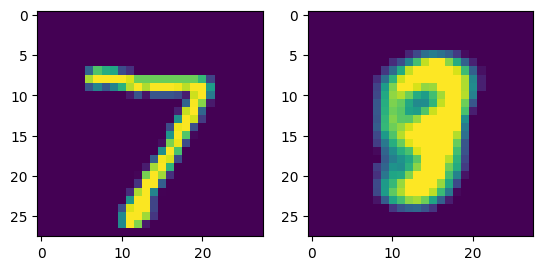

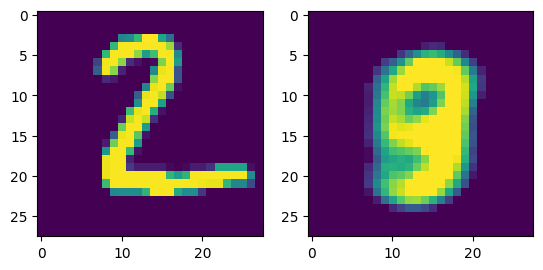

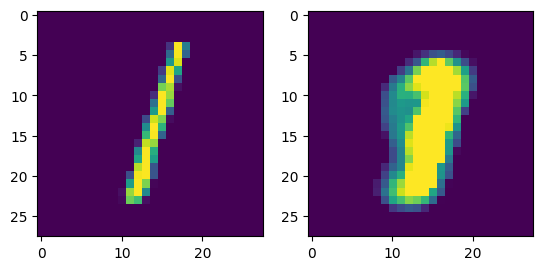

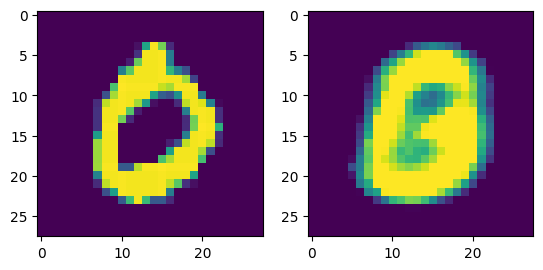

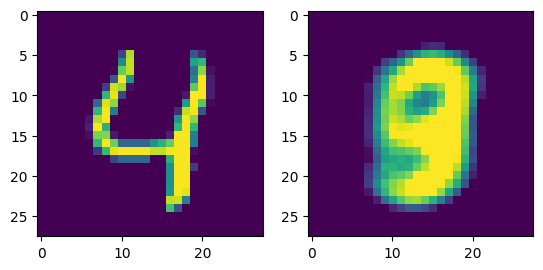

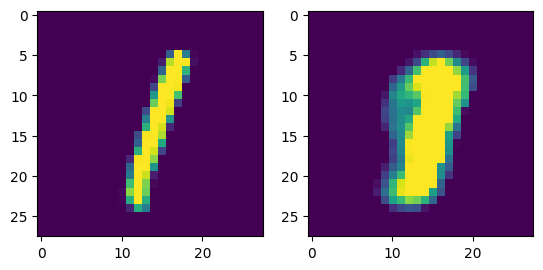

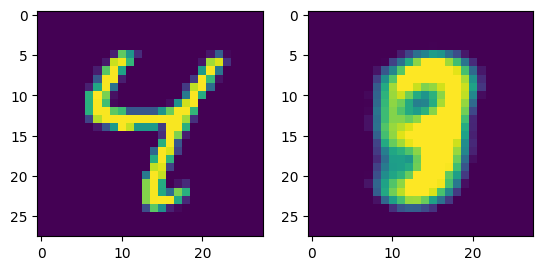

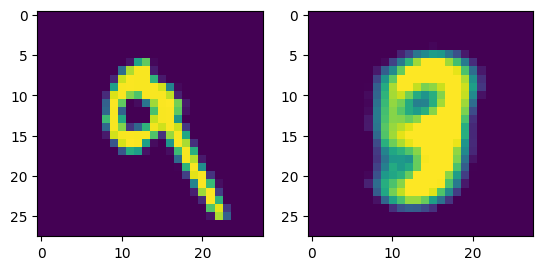

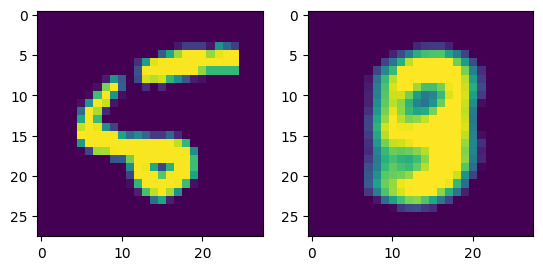

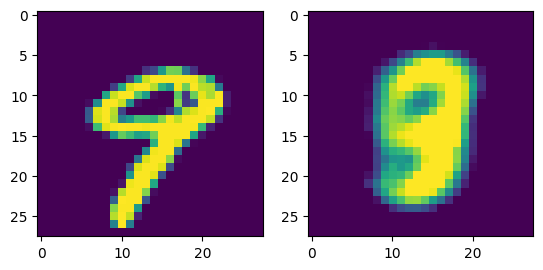

In [7]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _ = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())